In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
energy_data_link = "https://drive.google.com/open?id=1qGMiEIOig7l-IJvMkeepSbSBsPNSXTJj"
weather_data_link = "https://drive.google.com/open?id=1uQo7XFfIjAYo9zzGZLw6O8zft78PHmIr"
holiday_data_link = "https://drive.google.com/open?id=1mC-EU56ZKwXuGBWhXD2yF5xHUUY9mOIS"

In [0]:
fluff, id1 = energy_data_link.split('=')
fluff, id2 = weather_data_link.split('=')
fluff, id3 = holiday_data_link.split('=')

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
downloaded = drive.CreateFile({'id':id1}) 
downloaded.GetContentFile('energy_data.csv')
df = pd.read_csv("energy_data.csv")

In [6]:
df.head()

,Unnamed: 0,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,blockid
0,0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000,block_0
1,1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076,block_0
2,2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070,block_0
3,3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070,block_0
4,4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087,block_0


In [7]:
len(df)

3510433

In [0]:
df = df.dropna()

In [0]:
len(df)

3499102

The smart meters captures half hourly readings. So, daily energy is calculated by aggregating all the half hourly readings. Some entries do not have all 24 hr data, so we multiply the remaining factor by the median energy to normalize the energy value. 

In [0]:
df.loc[df['energy_count'] < 48, 'energy_sum'] = (48 - df['energy_count']) * df['energy_median'] + df['energy_sum']

In [10]:
housecount = df.groupby('day')[['LCLid']].count()
housecount

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41
2011-11-27,41
...,...
2014-02-23,4993
2014-02-24,4993
2014-02-25,4988


In [0]:
# data preprocessing for the energy dataset.
# We see that the number of houses on each day is not the same. So, we cannot use the energy_sum, energy_mean values directly for analysis.
# We calculate the energy/household so as to normalize the data.

In [11]:
# calculate the sum of total energy per day.
total_energy = df.groupby("day")[["energy_sum", "energy_median"]].sum()
total_energy

,energy_sum,energy_median
day,,
2011-11-23,159.349000,2.9660
2011-11-24,271.566000,4.8395
2011-11-25,340.373000,5.6890
2011-11-26,475.057000,8.3345
2011-11-27,444.883001,7.4235
...,...,...
2014-02-23,57385.034995,889.1295
2014-02-24,51998.895004,778.2475
2014-02-25,51444.665001,775.9130


In [13]:
energy_df = total_energy.merge(housecount, on=["day"])
energy_df = energy_df.reset_index()
energy_df

,day,energy_sum,energy_median,LCLid
0,2011-11-23,159.349000,2.9660,13
1,2011-11-24,271.566000,4.8395,25
2,2011-11-25,340.373000,5.6890,32
3,2011-11-26,475.057000,8.3345,41
4,2011-11-27,444.883001,7.4235,41
...,...,...,...,...
823,2014-02-23,57385.034995,889.1295,4993
824,2014-02-24,51998.895004,778.2475,4993
825,2014-02-25,51444.665001,775.9130,4988
826,2014-02-26,50953.459995,760.4445,4985


In [0]:
energy_df['energy_sum'] = energy_df['energy_sum']/energy_df['LCLid']
energy_df['energy_median'] = energy_df['energy_median']/energy_df['LCLid']
energy_df.drop(energy_df.tail(1).index,inplace=True)
energy_df['day'] = pd.to_datetime(energy_df['day'],format='%Y-%m-%d').dt.date
energy_df = energy_df.set_index('day')

In [0]:
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('weather_daily_darksky.csv')
weather_df = pd.read_csv("weather_daily_darksky.csv")
weather_df.head()

weather_df['day'] = pd.to_datetime(weather_df['time'],format='%Y-%m-%d').dt.date
weather_df = weather_df.drop('time', axis=1)
weather_df = weather_df.set_index('day')

In [30]:
weather_df.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-11,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
2011-12-11,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2011-12-27,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,rain,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
2011-12-02,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,rain,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
2011-12-24,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,5.02,rain,13.16,0.80,2011-12-24 15:00:00,4.37,5.32,1.0,2011-12-24 15:55:55,7.45,3.17,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


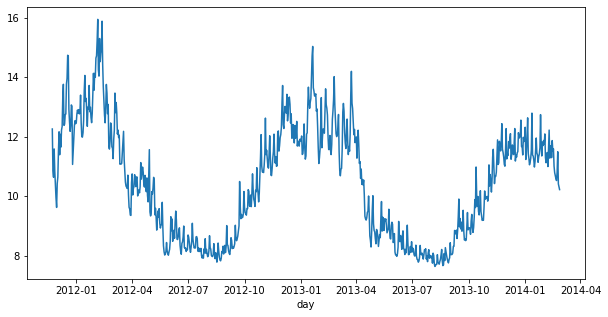

In [31]:
energy_df['energy_sum'].plot(figsize=(10,5))

In [32]:
merged_df = energy_df.merge(weather_df, how='inner', on='day')
merged_df_1 = merged_df.drop(['LCLid', 'temperatureMax', 'temperatureHigh', 'pressure', 'windBearing', 'windSpeed', 'apparentTemperatureHigh', 'apparentTemperatureLow', 'temperatureMin', 'apparentTemperatureMax', 'apparentTemperatureMin', 'temperatureMaxTime', 'temperatureMinTime', 'icon', 'apparentTemperatureMinTime', 'apparentTemperatureHighTime', 'precipType', 'visibility', 'sunsetTime', 'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary', 'temperatureLowTime', 'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'moonPhase'], axis=1)
merged_df_1.dropna(inplace=True)
merged_df_1.head()

,energy_sum,energy_median,dewPoint,cloudCover,humidity,uvIndex,temperatureLow
day,,,,,,,
2011-11-23,12.257615,0.228154,6.29,0.36,0.93,1.0,8.24
2011-11-24,10.862640,0.193580,8.56,0.41,0.89,1.0,9.71
2011-11-25,10.636656,0.177781,7.24,0.48,0.79,1.0,7.01
2011-11-26,11.586756,0.203280,6.96,0.44,0.81,1.0,11.59
2011-11-27,10.850805,0.181061,5.76,0.42,0.72,1.0,1.31


In [0]:
merged_df_1['temperature'] = merged_df_1['temperatureLow']

In [0]:
merged_df_1 = merged_df_1.drop('temperatureLow', axis=1)

In [35]:
merged_df_1.head()

,energy_sum,energy_median,dewPoint,cloudCover,humidity,uvIndex,temperature
day,,,,,,,
2011-11-23,12.257615,0.228154,6.29,0.36,0.93,1.0,8.24
2011-11-24,10.862640,0.193580,8.56,0.41,0.89,1.0,9.71
2011-11-25,10.636656,0.177781,7.24,0.48,0.79,1.0,7.01
2011-11-26,11.586756,0.203280,6.96,0.44,0.81,1.0,11.59
2011-11-27,10.850805,0.181061,5.76,0.42,0.72,1.0,1.31


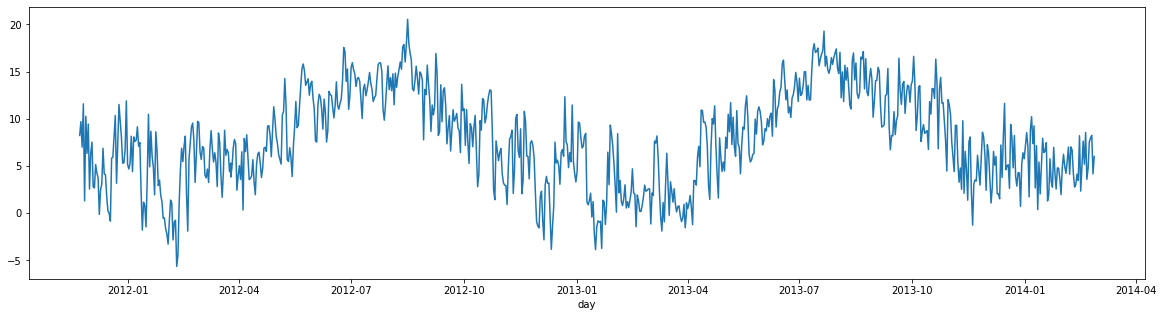

In [36]:
merged_df_1['temperature'].plot(figsize=(20,5))

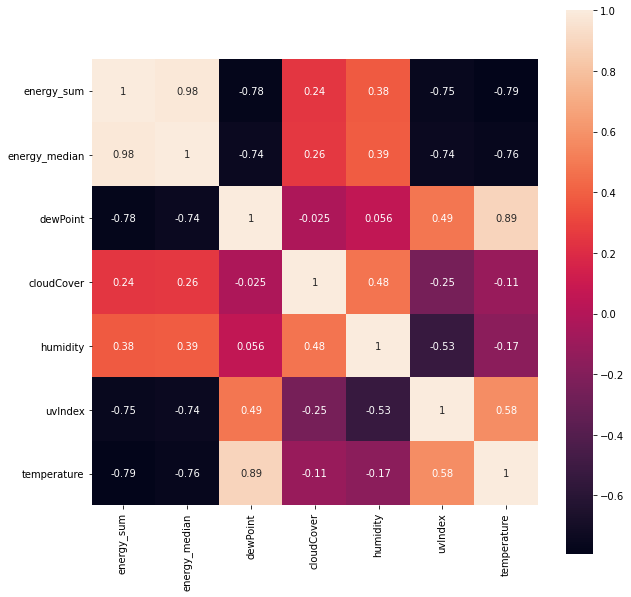

In [38]:
corr_matrix = merged_df_1.corr("pearson")
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, square=True, annot=True)

In [39]:
merged_df_1 = merged_df_1.sort_values(by=['day'])
merged_df_1

,energy_sum,energy_median,dewPoint,cloudCover,humidity,uvIndex,temperature
day,,,,,,,
2011-11-23,12.257615,0.228154,6.29,0.36,0.93,1.0,8.24
2011-11-24,10.862640,0.193580,8.56,0.41,0.89,1.0,9.71
2011-11-25,10.636656,0.177781,7.24,0.48,0.79,1.0,7.01
2011-11-26,11.586756,0.203280,6.96,0.44,0.81,1.0,11.59
2011-11-27,10.850805,0.181061,5.76,0.42,0.72,1.0,1.31
...,...,...,...,...,...,...,...
2014-02-22,10.804798,0.166571,2.64,0.25,0.71,2.0,7.52
2014-02-23,11.493097,0.178075,6.17,0.66,0.76,1.0,7.99
2014-02-24,10.414359,0.155868,6.03,0.50,0.74,1.0,8.25


In [40]:
merged_df_train = merged_df_1.iloc[0:len(merged_df_1) - 30]
len(merged_df_train)

796

In [41]:
merged_df_test = merged_df_1.iloc[len(merged_df_train):(len(merged_df_1))]
len(merged_df_test)

30

In [42]:
merged_df_train.head()

,energy_sum,energy_median,dewPoint,cloudCover,humidity,uvIndex,temperature
day,,,,,,,
2011-11-23,12.257615,0.228154,6.29,0.36,0.93,1.0,8.24
2011-11-24,10.862640,0.193580,8.56,0.41,0.89,1.0,9.71
2011-11-25,10.636656,0.177781,7.24,0.48,0.79,1.0,7.01
2011-11-26,11.586756,0.203280,6.96,0.44,0.81,1.0,11.59
2011-11-27,10.850805,0.181061,5.76,0.42,0.72,1.0,1.31


In [43]:
merged_df_test.head()

,energy_sum,energy_median,dewPoint,cloudCover,humidity,uvIndex,temperature
day,,,,,,,
2014-01-28,11.350840,0.174510,3.59,0.61,0.83,1.0,4.76
2014-01-29,11.818320,0.187820,3.05,0.93,0.90,1.0,3.66
2014-01-30,11.697604,0.183157,3.08,0.81,0.91,1.0,1.97
2014-01-31,11.871105,0.187204,3.93,0.73,0.91,1.0,4.83
2014-02-01,11.746686,0.184630,3.18,0.19,0.76,1.0,6.24


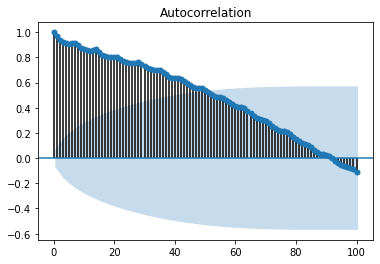

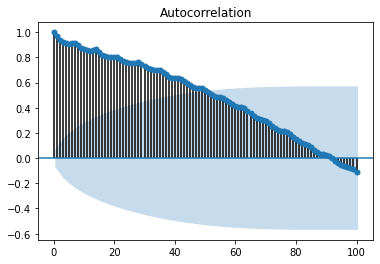

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(merged_df_train['energy_sum'], lags=100)

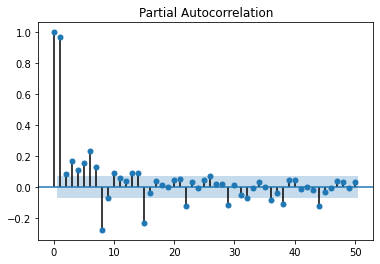

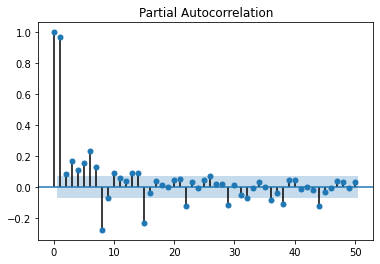

In [45]:
plot_pacf(merged_df_train['energy_sum'], lags=50)

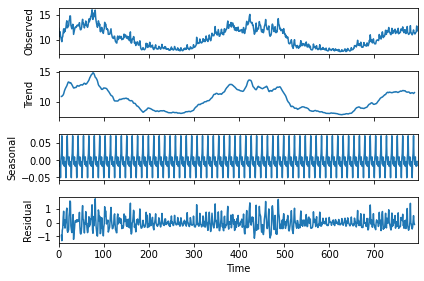

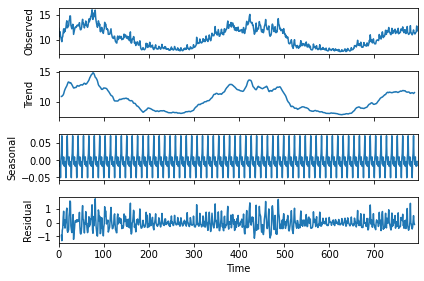

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(merged_df_train.energy_sum.values, model='additive', freq=12)
result.plot()

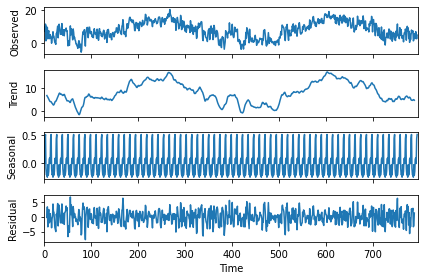

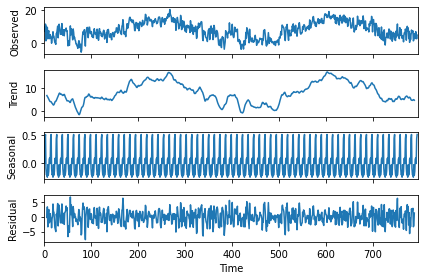

In [47]:
result1 = seasonal_decompose(merged_df_train.temperature.values, model='additive', freq=12)
result1.plot()

In [0]:
# Dependent variables (time series data)
endog = merged_df_train[['energy_sum', 'energy_median', 'temperature']]

In [49]:
#Augmented Dickey Fuller test for stationarity check.
from statsmodels.tsa.stattools import adfuller
X = endog['energy_sum'].values
result = adfuller(X)
print(result)

X = endog['temperature'].values
result = adfuller(X)
print(result)

X = endog['energy_median'].values
result = adfuller(X)
print(result)

(-1.9228393845158236, 0.3213941907806714, 21, 774, {'1%': -3.4388268991356936, '5%': -2.8652813916285518, '10%': -2.5687622857867782}, 793.8171825618622)
(-3.1484863567399617, 0.02316692514734906, 5, 790, {'1%': -3.4386546523763837, '5%': -2.865205472974755, '10%': -2.568721842653421}, 3612.0047112482716)
(-2.0690035812054655, 0.2571596394454061, 15, 780, {'1%': -3.4387614757350087, '5%': -2.865252556432172, '10%': -2.5687469247205788}, -5257.128054290431)


2 out of 3 are not stationary. Difference it to make it stationary. Seasonal depcomposition shows most of it is trend, so just difference the time series

In [0]:
merged_df_train_diff = endog.diff().dropna()
#merged_df_train_diff['energy_sum'] = [endog['energy_sum'][i] - endog['energy_sum'][i-interval] for i in range(interval, len(endog['energy_sum']))]

In [51]:
merged_df_train_diff.head()
len(merged_df_train_diff)

795

In [52]:
#Augmented Dickey Fuller test for stationarity check.
X = merged_df_train_diff['energy_sum'].values
result = adfuller(X)
print(result)

X = merged_df_train_diff['temperature'].values
result = adfuller(X)
print(result)

X = merged_df_train_diff['energy_median'].values
result = adfuller(X)
print(result)

(-6.518646129008742, 1.0556919146367507e-08, 20, 774, {'1%': -3.4388268991356936, '5%': -2.8652813916285518, '10%': -2.5687622857867782}, 795.6210121795662)
(-20.625138525050087, 0.0, 4, 790, {'1%': -3.4386546523763837, '5%': -2.865205472974755, '10%': -2.568721842653421}, 3615.942594283475)
(-8.638429941204704, 5.509355000538745e-14, 13, 781, {'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}, -5246.554852693507)


In [0]:
#Second diff.
#merged_df_train_diff = merged_df_train_diff.diff().dropna()

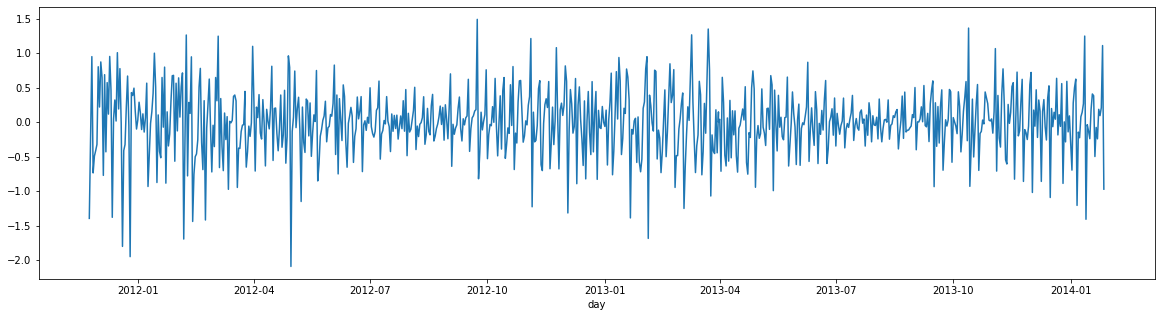

In [53]:
merged_df_train_diff['energy_sum'].plot(figsize=(20,5))

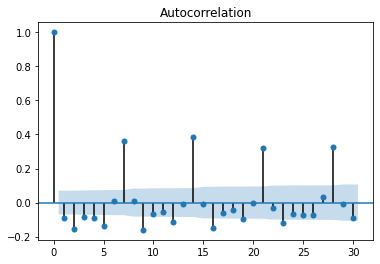

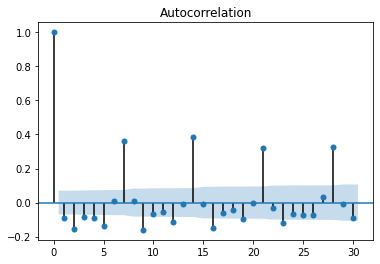

In [54]:
plot_acf(merged_df_train_diff['energy_sum'])

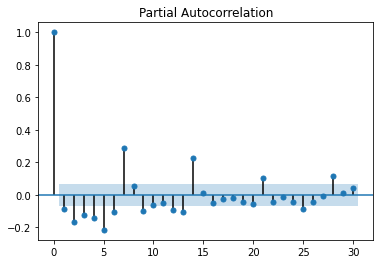

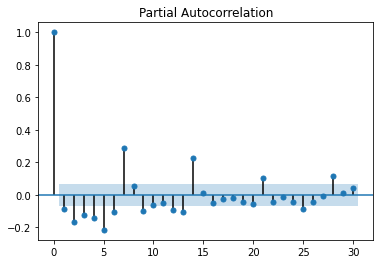

In [55]:
plot_pacf(merged_df_train_diff['energy_sum'])

In [0]:
# Granger's causality test to check time series inter dependence.
from statsmodels.tsa.stattools import grangercausalitytests
test1_a = grangercausalitytests(merged_df_train_diff[['energy_sum', 'energy_median']], maxlag=20, verbose=False)
test1_b = grangercausalitytests(merged_df_train_diff[['energy_median', 'energy_sum']], maxlag=20, verbose=False)
test2_a = grangercausalitytests(merged_df_train_diff[['energy_sum', 'temperature']], maxlag=20, verbose=False)
test2_b = grangercausalitytests(merged_df_train_diff[['temperature', 'energy_sum']], maxlag=20, verbose=False)
test3_a = grangercausalitytests(merged_df_train_diff[['temperature', 'energy_median']], maxlag=20, verbose=False)
test3_b = grangercausalitytests(merged_df_train_diff[['energy_median', 'temperature']], maxlag=20, verbose=False)

In [74]:
#Extract the p-value
test1_a[1][0]['ssr_chi2test'][1]

4.366602946511025e-05

In [0]:
min_p_value = min([round(test1_a[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)])
print(min_p_value)

print(min([round(test1_b[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)]))

print(min([round(test2_a[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)]))

print(min([round(test2_b[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)]))

print(min([round(test3_a[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)]))

print(min([round(test3_b[i+1][0]['ssr_chi2test'][1], 4) for i in range(maxlag)]))

In [75]:
from statsmodels.tsa.api import VAR
model_var = VAR(merged_df_train_diff)
results_var = model_var.fit(ic='aic')
results_var.aic

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-12.21586049502404

In [76]:
# Durbin watson test for residual correlation check.
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results_var.resid)
print(out)

[2.00231893 1.9976148  2.00565032]


In [77]:
lag_order = results_var.k_ar
print(lag_order)

18


In [78]:
forecast_inp = merged_df_train_diff.values[-lag_order:]
len(forecast_inp)

18

In [80]:
fc = results_var.forecast(y=forecast_inp, steps=len(merged_df_test)) 
df_forecast = pd.DataFrame(fc, index=merged_df_test.index[-len(merged_df_test):], columns=['energy_sum', 'energy_median', 'temperature'])
df_forecast.head()

,energy_sum,energy_median,temperature
day,,,
2014-01-28,-0.235533,-0.003487,0.123546
2014-01-29,-0.133873,-0.001259,-0.770571
2014-01-30,0.043621,-0.000062,-0.086563
2014-01-31,-0.037945,0.000703,0.160701
2014-02-01,0.389551,0.007753,0.042083


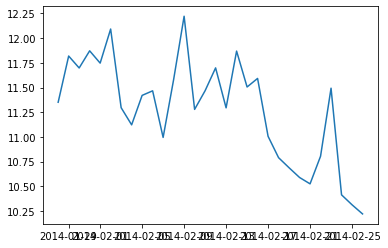

In [81]:
plt.plot(merged_df_test['energy_sum'])

In [82]:
len(df_forecast)

30

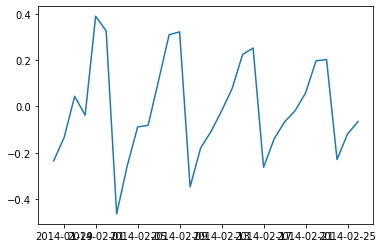

In [83]:
plt.plot(df_forecast['energy_sum'])
#Without converting back to scale.

In [84]:
df_forecast_inverse = df_forecast.copy()

# Invert second difference
#df_forecast_inverse['energy_sum'] = (merged_df_train['energy_sum'].iloc[-1] - merged_df_train['energy_sum'].iloc[-2]) + df_forecast_inverse['energy_sum'].cumsum()
# Invert first difference.
print(merged_df_train['energy_sum'].iloc[-1])
df_forecast_inverse['energy_sum'] = merged_df_train['energy_sum'].iloc[-1] + df_forecast_inverse['energy_sum'].cumsum()

11.768652312425937


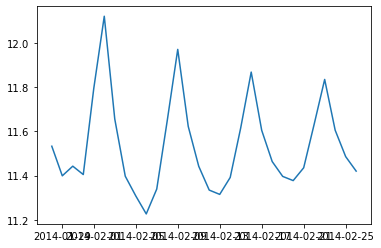

In [85]:
plt.plot(df_forecast_inverse['energy_sum'])

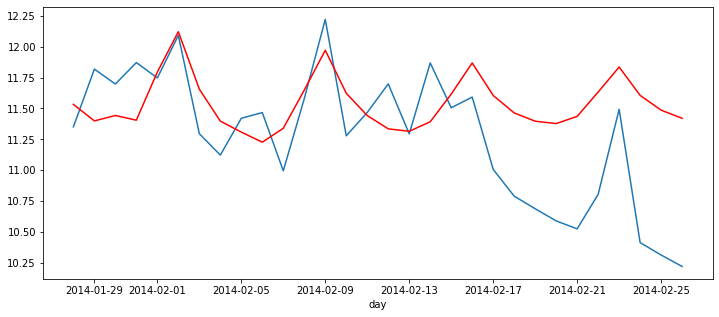

In [86]:
ax = merged_df_test['energy_sum'].plot(figsize=(12,5))
df_forecast_inverse['energy_sum'].plot(ax=ax, color = 'red')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
merged_output = df_forecast_inverse.merge(merged_df_test, how='inner', on='day')
merged_output = merged_output.rename({'energy_sum_x': 'Predicted', 'energy_sum_y': 'Actual'}, axis=1)
merged_output_final = merged_output[['Predicted', 'Actual']]
merged_output_final.head()
merged_output_final.to_csv('/content/drive/My Drive/Colab Notebooks/var_output.csv')

In [87]:
#evaluation

#MAE
mae = np.mean(np.abs(df_forecast_inverse['energy_sum'] - merged_df_test['energy_sum']))
print(mae)

#RMSE
rmse = np.mean((df_forecast_inverse['energy_sum'] - merged_df_test['energy_sum'])**2)**0.5
print(rmse)

#MAPE
mape = np.mean(np.abs(df_forecast_inverse['energy_sum'] - merged_df_test['energy_sum']) / np.abs(merged_df_test['energy_sum'])) * 100
print(mape)

0.43592198521603315
0.5573516418595164
3.9967557229631447
